In [1]:
import pandas as pd # standard
import numpy as np # standard
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # for accuracy calculation
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import thermogram_utilities

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")

# replace NA with control
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

# get location of cut off values
lower_column_index = df.columns.get_loc("T51")
upper_column_index = df.columns.get_loc("T85.1")
label_column_index = df.columns.get_loc("CancerType")

column_indices = np.arange(lower_column_index, upper_column_index)
column_indices = np.append(column_indices, 0)
column_indices = np.append(column_indices, 1)



column_indices = np.append(column_indices, label_column_index)

df = df.iloc[:, column_indices]

# keep only Control and Adenocarcinoma for analysis
df_tree = df[(df['CancerType'] == 'Control') | (df['CancerType'] == 'Adenocarcinoma')]
df_tree = df_tree.reset_index(drop=True)

In [3]:
df_tree_dif1 = df_tree.select_dtypes(include=['number']).diff(axis = 1)
non_numeric_columns = df_tree.select_dtypes(exclude=['number'])
df_tree_dif1 = pd.concat( [df_tree_dif1, non_numeric_columns], axis=1)
df_tree_dif1 = df_tree_dif1.iloc[:, 1:]

df_long = pd.melt(df_tree_dif1, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )
df_long['temp'] = df_long['temp'].str.replace('T', '').astype(float)

In [4]:
temps = df_tree_dif1.drop(['CancerType', 'sample_id', 'pub_id'], axis = 1).columns.str.replace('T', '')
temps = temps.astype(float)
feature_importance = pd.DataFrame({"Temperature":temps})

# length of df
num_rows = df_tree_dif1.shape[0]

# number of bootstraps
total_bootstraps = 100

# create results df
performance_metrics = pd.DataFrame(columns=['Weighted Accuracy', 'AUC'])

# create array of all indices in full data set
all_indices = np.arange(num_rows)

# columns to drop
drop_cols = ['sample_id', 'pub_id', 'CancerType']

# loop to bootstrap and validate many times
for i in range(total_bootstraps):


    # sample indices with replacement of df
    train_indices = np.random.choice(num_rows, num_rows, replace = True)

    # get the train set using the indices
    train_set = df_tree_dif1.iloc[train_indices, : ]

    # get the indices not selected
    test_indices = np.setdiff1d(all_indices, train_indices)

    # use not selected indices as the train set
    test_set = df_tree_dif1.iloc[test_indices, : ]
    
    # train decision tree
    clf = RandomForestClassifier()
    clf = clf.fit( train_set.drop(drop_cols, axis = 1), train_set['CancerType'])

    # get probabilities
    test_probabilities = clf.predict_proba(test_set.drop(drop_cols, axis = 1))

    # test decision tree
    test_predictions = clf.predict(test_set.drop(drop_cols, axis = 1))

    # calculate weighted accuracy
    balanced_acc = balanced_accuracy_score(test_set['CancerType'], test_predictions)

    # calculate AUC
    auc = roc_auc_score(test_set['CancerType'] == 'Control', test_probabilities[:, 1])

    # append accuracy, auc to results df
    performance_metrics.loc[len(performance_metrics)] = [balanced_acc, auc]

    feature_importance_tree = clf.feature_importances_

    feature_importance[i] = feature_importance_tree


In [5]:
median_difference = thermogram_utilities.median_curve(df_long, "CancerType",'temp', 'dsp')

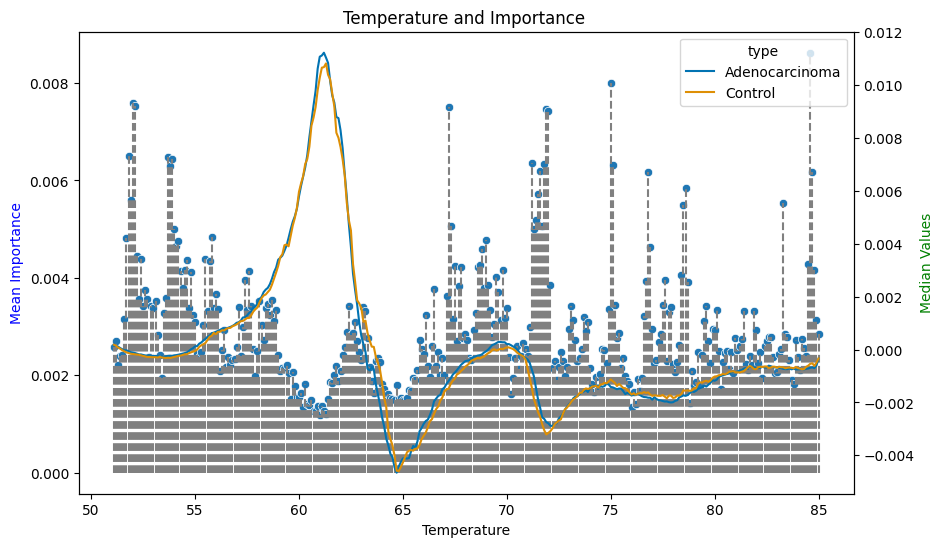

In [6]:
feature_importance_long = pd.melt(feature_importance, id_vars=['Temperature'], var_name='Fold', value_name='Importance' )
feature_importance.iloc[:, 1:].mean(axis=1)

temps = temps.astype(float)
mean_feature_importance = pd.DataFrame({"Temperature":temps, "Mean Importance": feature_importance.iloc[:, 1:].mean(axis=1)
})
# Create a figure with a specific size
plt.figure(figsize=(10, 6))

# Create a bar plot for "Importance"
ax1 = sns.scatterplot(data=mean_feature_importance, x='Temperature', y='Mean Importance')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Create a line plot for "Median" on the secondary y-axis
#sns.lineplot(data=median_difference, x='temperature', y='median', hue='type', palette='colorblind', ax=ax2)

# Add vertical lines from the points to the x-axis for the bar plot
for index, row in mean_feature_importance.iterrows():
    x_value = row['Temperature']
    y_value = row['Mean Importance']
    ax1.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


sns.lineplot(data=median_difference, x='temperature', y='median', hue='type', palette='colorblind', ax=ax2)

# Set labels for both y-axes
ax1.set_ylabel('Mean Importance', color='blue')
ax2.set_ylabel('Median Values', color='green')

# Add a legend
#lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Add labels and title
plt.xlabel('Temperature')
plt.title('Temperature and Importance ')

# Show the plot
plt.show()


<Axes: ylabel='Weighted Accuracy'>

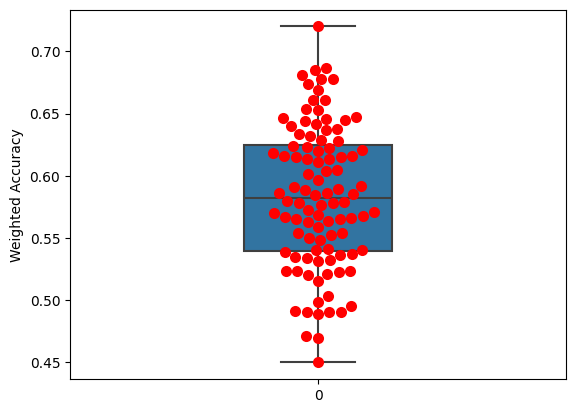

In [7]:
sns.boxplot(data=performance_metrics['Weighted Accuracy'], width=0.3)

# Add points to the boxplot using the swarmplot function
sns.swarmplot(data=performance_metrics['Weighted Accuracy'], color='red', size=8)

In [8]:
print({performance_metrics['Weighted Accuracy'].mean()}, {performance_metrics['AUC'].mean()})

{0.5834521696266137} {0.662194797510571}


<Axes: xlabel='Weighted Accuracy', ylabel='Count'>

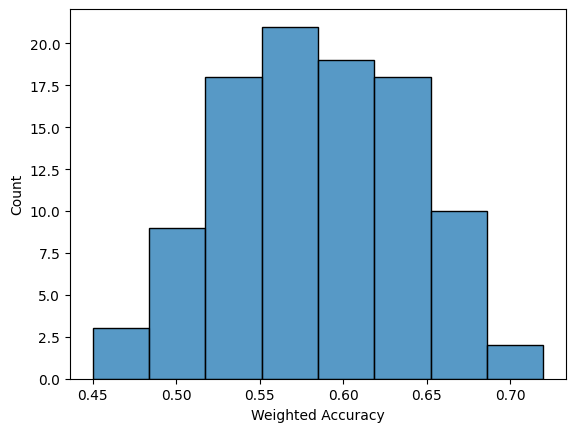

In [9]:
sns.histplot(data=performance_metrics['Weighted Accuracy'])


In [10]:
'''temps = df_tree_dif1.drop(['CancerType', 'sample_id', 'pub_id'], axis = 1).columns.str.replace('T', '')
temps = temps.astype(float)
feature_importance = pd.DataFrame({"Temperature":temps})

# length of df
num_rows = df_tree_dif1.shape[0]

# number of bootstraps
total_bootstraps = 100

# create results df
performance_metrics = pd.DataFrame(columns=['Weighted Accuracy', 'AUC'])

# create array of all indices in full data set
all_indices = np.arange(num_rows)

# columns to drop
drop_cols = ['sample_id', 'pub_id', 'CancerType']

# loop to bootstrap and validate many times
#for i in range(total_bootstraps):


# sample indices with replacement of df
train_indices = np.random.choice(num_rows, num_rows, replace = True)

    # get the train set using the indices
train_set = df_tree_dif1.iloc[train_indices, : ]

# get the indices not selected
test_indices = np.setdiff1d(all_indices, train_indices)

# use not selected indices as the train set
test_set = df_tree_dif1.iloc[test_indices, : ]

# train decision tree
clf = RandomForestClassifier()
clf = clf.fit( train_set.drop(drop_cols, axis = 1), train_set['CancerType'])

# get probabilities
test_probabilities = clf.predict_proba(test_set.drop(drop_cols, axis = 1))

# test decision tree
test_predictions = clf.predict(test_set.drop(drop_cols, axis = 1))

# calculate weighted accuracy
balanced_acc = balanced_accuracy_score(test_set['CancerType'], test_predictions)

# calculate AUC
auc = roc_auc_score(test_set['CancerType'] == 'Control', test_probabilities[:, 1])

# append accuracy, auc to results df
performance_metrics.loc[len(performance_metrics)] = [balanced_acc, auc]

feature_importance_tree = clf.feature_importances_

feature_importance[0] = feature_importance_tree'''


'temps = df_tree_dif1.drop([\'CancerType\', \'sample_id\', \'pub_id\'], axis = 1).columns.str.replace(\'T\', \'\')\ntemps = temps.astype(float)\nfeature_importance = pd.DataFrame({"Temperature":temps})\n\n# length of df\nnum_rows = df_tree_dif1.shape[0]\n\n# number of bootstraps\ntotal_bootstraps = 100\n\n# create results df\nperformance_metrics = pd.DataFrame(columns=[\'Weighted Accuracy\', \'AUC\'])\n\n# create array of all indices in full data set\nall_indices = np.arange(num_rows)\n\n# columns to drop\ndrop_cols = [\'sample_id\', \'pub_id\', \'CancerType\']\n\n# loop to bootstrap and validate many times\n#for i in range(total_bootstraps):\n\n\n# sample indices with replacement of df\ntrain_indices = np.random.choice(num_rows, num_rows, replace = True)\n\n    # get the train set using the indices\ntrain_set = df_tree_dif1.iloc[train_indices, : ]\n\n# get the indices not selected\ntest_indices = np.setdiff1d(all_indices, train_indices)\n\n# use not selected indices as the train set\n